In [1]:
from sklearn.metrics import *
from tqdm import tqdm
import numpy as np
import pyvista as pv
import open3d as o3d
from sklearn.cluster import KMeans

from final_models_explainability.get_predictions import *

## Explainability evaluation by comparing left and right hippocampal attributions
### Evaluating left and right hippocampus model

              precision    recall  f1-score   support

          CN       0.48      0.62      0.54        60
         MCI       0.77      0.65      0.70       115

    accuracy                           0.64       175
   macro avg       0.62      0.63      0.62       175
weighted avg       0.67      0.64      0.65       175

roc_auc: 0.6344202898550725


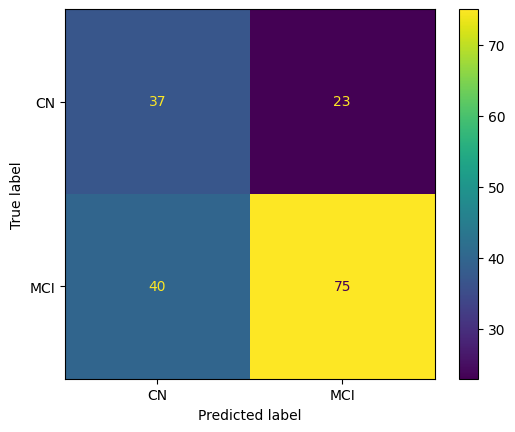

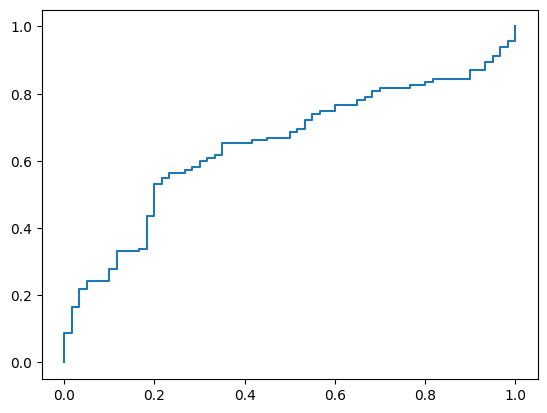

In [2]:
results = np.load("lr_pointnet_eval.npz")

# Eval
report = classification_report(results['true'], results['pred_classes'], target_names=['CN', 'MCI'])

print(report)

roc_auc = roc_auc_score(results['true'], results['pred_classes'])

print(f"roc_auc: {roc_auc}")

fpr, tpr, thresholds = roc_curve(results['true'], results['pred_probs'])

conf_matrix = confusion_matrix(results['true'], results['pred_classes'])

conf_matrix_disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['CN','MCI'])

conf_matrix_disp.plot()

plt.show()

plt.plot(fpr, tpr)

plt.show()

### Evaluate explainability for correct positive predictions

In [3]:
# Filter the results into only the correct positive predictions

results = np.load("lr_pointnet_eval.npz")

correct_indices = []

for i in range(len(results['true'])):

    if results['true'][i] == 1 and results['pred_classes'][i] == 1:

        correct_indices.append(i)

filtered_results = {
                    'true': [results['true'][i] for i in correct_indices],
                    'pred_probs': [results['pred_probs'][i] for i in correct_indices],
                    'data': [results['data'][i] for i in correct_indices], 
                    'attributions_list': [results['attributions_list'][i] for i in correct_indices]
                    
                }

In [4]:
# Use the first hippocampus as a template, add it to the plotter

transformed_clouds_concat = []
attributions_concat = []
opacity_scalars_concat = []

target_pcd = o3d.geometry.PointCloud()

target_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][0])

target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

target_pcd.orient_normals_consistent_tangent_plane(10)

#o3d.visualization.draw_geometries([target_pcd], point_show_normal=True)

transformed_clouds_concat.extend(filtered_results['data'][0])

norm_xyz_sum = normalise_attributions(filtered_results['attributions_list'][0], power = 0.2)

attributions_concat.extend(norm_xyz_sum)

opacity_scalars_concat.extend(np.clip(np.abs(norm_xyz_sum - 0.5), 0.05 , 0.8))

# Align all other point clouds with the first, and display. Note, does normalisation of attributions in range 0,1 affect the output?
for i in range(len(filtered_results['true']))[1:]:
    
    trans_init = np.eye(4)

    moving_pcd = o3d.geometry.PointCloud()

    moving_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][i])

    moving_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

    moving_pcd.orient_normals_consistent_tangent_plane(5)

    reg = o3d.pipelines.registration.registration_icp(moving_pcd, target_pcd, 5, trans_init, o3d.pipelines.registration.TransformationEstimationPointToPlane())

    moving_pcd.transform(reg.transformation)

    transformed_clouds_concat.extend(np.asarray(moving_pcd.points))

    norm_xyz_sum = normalise_attributions(filtered_results['attributions_list'][i], power = 0.2)

    attributions_concat.extend(norm_xyz_sum)

    opacity_scalars_concat.extend(np.clip(np.abs(norm_xyz_sum - 0.5), 0.05 , 0.8))

transformed_clouds_concat = np.array(transformed_clouds_concat)
attributions_concat = np.array(attributions_concat)
opacity_scalars_concat = np.array(opacity_scalars_concat)


In [5]:


kmeans = KMeans(n_clusters=2, random_state = 42)
cluster_labels = kmeans.fit_predict(transformed_clouds_concat)

cluster_avg_attr = np.zeros_like(attributions_concat)

cluster_0_mask = (cluster_labels == 0)
cluster_1_mask = (cluster_labels == 1)

points_0 = transformed_clouds_concat[cluster_0_mask]
attributions_0 = attributions_concat[cluster_0_mask]
opacities_0 = opacity_scalars_concat[cluster_0_mask]
points_1 = transformed_clouds_concat[cluster_1_mask]
attributions_1 = attributions_concat[cluster_1_mask]
opacities_1 = opacity_scalars_concat[cluster_1_mask]

mean_attr_0 = np.mean(np.abs(attributions_0 - 0.5))
mean_attr_1 = np.mean(np.abs(attributions_1 - 0.5))

print(mean_attr_0, mean_attr_1)

0.03665229652027591 0.06098348076859892


In [6]:
plotter = pv.Plotter()

colours = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours)

cloud_0 = pv.PolyData(points_0)
cloud_1 = pv.PolyData(points_1)

plotter.add_points(cloud_0, scalars=attributions_0, cmap=custom_cmap, clim= [0,1], opacity= opacities_0)

plotter.add_points(cloud_1, scalars=attributions_1, cmap=custom_cmap, clim= [0,1], opacity= opacities_1)

midpoint_0 = points_0.mean(axis=0)

midpoint_1 = points_1.mean(axis=0)

# NB labels need to be manually assigned by comparing shapes as k means keeps switching labels
plotter.add_point_labels([midpoint_0.tolist()], [f"{mean_attr_0:.4f}"], text_color='white')
plotter.add_point_labels([midpoint_1.tolist()], [f"{mean_attr_1:.4f}"], text_color='white')

plotter.set_background("black")

plotter.show()

Widget(value='<iframe src="http://localhost:52338/index.html?ui=P_0x16c28b620_0&reconnect=auto" class="pyvista…

### Evaluate explainability for all correct predictions

In [7]:
# Filter the results into only the correct positive predictions

results = np.load("lr_pointnet_eval.npz")

correct_indices = []

for i in range(len(results['true'])):

    if results['true'][i] == results['pred_classes'][i]:

        correct_indices.append(i)

filtered_results = {
                    'true': [results['true'][i] for i in correct_indices],
                    'pred_probs': [results['pred_probs'][i] for i in correct_indices],
                    'data': [results['data'][i] for i in correct_indices], 
                    'attributions_list': [results['attributions_list'][i] for i in correct_indices]
                    
                }

In [8]:
# Use the first hippocampus as a template, add it to the plotter

transformed_clouds_concat = []
attributions_concat = []
opacity_scalars_concat = []

target_pcd = o3d.geometry.PointCloud()

target_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][0])

target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

target_pcd.orient_normals_consistent_tangent_plane(10)

#o3d.visualization.draw_geometries([target_pcd], point_show_normal=True)

transformed_clouds_concat.extend(filtered_results['data'][0])

# Sum x, y and z values for an overall attribution for that point
xyz_sum = np.sum(filtered_results['attributions_list'][0], axis=1)

# Apply power for better vis
xyz_sum = np.sign(xyz_sum) * np.power(np.abs(xyz_sum), 0.3)

xyz_sum = np.abs(xyz_sum)

norm_xyz_sum =  xyz_sum/np.max(xyz_sum)

opacity_scalars_concat.extend(np.clip(norm_xyz_sum, 0.01 , 0.8))

attributions_concat.extend(norm_xyz_sum)

# Align all other point clouds with the first, and display. Note, does normalisation of attributions in range 0,1 affect the output?
for i in range(len(filtered_results['true']))[1:]:
    
    trans_init = np.eye(4)

    moving_pcd = o3d.geometry.PointCloud()

    moving_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][i])

    moving_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

    moving_pcd.orient_normals_consistent_tangent_plane(5)

    reg = o3d.pipelines.registration.registration_icp(moving_pcd, target_pcd, 5, trans_init, o3d.pipelines.registration.TransformationEstimationPointToPlane())

    moving_pcd.transform(reg.transformation)

    transformed_clouds_concat.extend(np.asarray(moving_pcd.points))

    # Sum x, y and z values for an overall attribution for that point
    xyz_sum = np.sum(filtered_results['attributions_list'][i], axis=1)

    # Apply power for better vis
    xyz_sum = np.sign(xyz_sum) * np.power(np.abs(xyz_sum), 0.3)

    xyz_sum = np.abs(xyz_sum)

    norm_xyz_sum =  xyz_sum/np.max(xyz_sum)

    opacity_scalars_concat.extend(np.clip(norm_xyz_sum, 0.01 , 0.8))

    attributions_concat.extend(norm_xyz_sum)

transformed_clouds_concat = np.array(transformed_clouds_concat)
attributions_concat = np.array(attributions_concat)
opacity_scalars_concat = np.array(opacity_scalars_concat)


In [9]:


kmeans = KMeans(n_clusters=2, random_state = 42)
cluster_labels = kmeans.fit_predict(transformed_clouds_concat)

cluster_avg_attr = np.zeros_like(attributions_concat)

cluster_0_mask = (cluster_labels == 0)
cluster_1_mask = (cluster_labels == 1)

points_0 = transformed_clouds_concat[cluster_0_mask]
attributions_0 = attributions_concat[cluster_0_mask]
opacities_0 = opacity_scalars_concat[cluster_0_mask]
points_1 = transformed_clouds_concat[cluster_1_mask]
attributions_1 = attributions_concat[cluster_1_mask]
opacities_1 = opacity_scalars_concat[cluster_1_mask]

mean_attr_0 = np.mean(attributions_0)
mean_attr_1 = np.mean(attributions_1)

print(mean_attr_0, mean_attr_1)

0.08251925933492643 0.04679948698275074


In [10]:
plotter = pv.Plotter()

colours = [(0, 'white'), (1, 'red')]
    
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours)

cloud_0 = pv.PolyData(points_0)
cloud_1 = pv.PolyData(points_1)

plotter.add_points(cloud_0, scalars=attributions_0, cmap=custom_cmap, clim= [0,1], opacity=opacities_0)

plotter.add_points(cloud_1, scalars=attributions_1, cmap=custom_cmap, clim= [0,1], opacity=opacities_1)

midpoint_0 = points_0.mean(axis=0)

midpoint_1 = points_1.mean(axis=0)

# NB labels need to be manually assigned by comparing shapes as k means keeps switching labels
plotter.add_point_labels([midpoint_0.tolist()], [f"{mean_attr_0:.4f}"], text_color='white')
plotter.add_point_labels([midpoint_1.tolist()], [f"{mean_attr_1:.4f}"], text_color='white')

plotter.set_background("black")

plotter.show()

Widget(value='<iframe src="http://localhost:52338/index.html?ui=P_0x16c24eea0_1&reconnect=auto" class="pyvista…

## Evaluation of pointnet explainability by global explainability
### Global explainability for correct positive predictions

In [11]:
# Filter the results into only the correct positive predictions

results = np.load("pointnet_eval.npz")

correct_indices = []

for i in range(len(results['true'])):

    if results['true'][i] == 1 and results['pred_classes'][i] == 1:

        correct_indices.append(i)

filtered_results = {
                    'true': [results['true'][i] for i in correct_indices],
                    'pred_probs': [results['pred_probs'][i] for i in correct_indices],
                    'data': [results['data'][i] for i in correct_indices], 
                    'attributions_list': [results['attributions_list'][i] for i in correct_indices]
}

print(len(filtered_results['data']))

69


In [12]:
# Use the first hippocampus as a template, add it to the plotter

plotter = pv.Plotter()

colours = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours)

target_pcd = o3d.geometry.PointCloud()

target_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][0])

target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

target_pcd.orient_normals_consistent_tangent_plane(5)

# o3d.visualization.draw_geometries([target_pcd], point_show_normal=True)

target_pv_cloud = pv.PolyData(filtered_results['data'][0])

norm_xyz_sum = normalise_attributions(filtered_results['attributions_list'][0], power = 0.2)

opacity_scalars = np.clip(np.abs(norm_xyz_sum - 0.5), 0.05 , 0.8)

plotter.add_points(target_pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim=[0,1], opacity=opacity_scalars)

# Align all other point clouds with the first, and display. Note, does normalisation of attributions in range 0,1 affect the output?
for i in range(len(filtered_results['true']))[1:]:
    
    trans_init = np.eye(4)

    moving_pcd = o3d.geometry.PointCloud()

    moving_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][i])

    moving_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

    moving_pcd.orient_normals_consistent_tangent_plane(5)

    reg = o3d.pipelines.registration.registration_icp(moving_pcd, target_pcd, 5, trans_init, o3d.pipelines.registration.TransformationEstimationPointToPlane())

    moving_pcd.transform(reg.transformation)

    transformed_pv_cloud = pv.PolyData(np.asarray(moving_pcd.points))

    norm_xyz_sum = normalise_attributions(filtered_results['attributions_list'][i], power = 0.2)

    opacity_scalars = np.clip(np.abs(norm_xyz_sum - 0.5), 0.05 , 0.8)

    plotter.add_points(transformed_pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim= [0,1], opacity=opacity_scalars)

plotter.set_background("black")

plotter.show()


Widget(value='<iframe src="http://localhost:52338/index.html?ui=P_0x16c27a000_2&reconnect=auto" class="pyvista…

### Global explainability for correct negative predictions

In [13]:
# Filter the results into only the correct positive predictions

results = np.load("pointnet_eval.npz")

correct_indices = []

for i in range(len(results['true'])):

    if results['true'][i] == 0 and results['pred_classes'][i] == 0:

        correct_indices.append(i)

filtered_results = {
                    'true': [results['true'][i] for i in correct_indices],
                    'pred_probs': [results['pred_probs'][i] for i in correct_indices],
                    'data': [results['data'][i] for i in correct_indices], 
                    'attributions_list': [results['attributions_list'][i] for i in correct_indices]
}

print(len(filtered_results['data']))

44


In [14]:
# Use the first hippocampus as a template, add it to the plotter

plotter = pv.Plotter()

colours = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours)

target_pcd = o3d.geometry.PointCloud()

target_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][0])

target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

target_pcd.orient_normals_consistent_tangent_plane(5)

# o3d.visualization.draw_geometries([target_pcd], point_show_normal=True)

target_pv_cloud = pv.PolyData(filtered_results['data'][0])

norm_xyz_sum = normalise_attributions(filtered_results['attributions_list'][0], power = 0.2)

opacity_scalars = np.clip(np.abs(norm_xyz_sum - 0.5), 0.05 , 0.8)

plotter.add_points(target_pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim=[0,1], opacity=opacity_scalars)

# Align all other point clouds with the first, and display. Note, does normalisation of attributions in range 0,1 affect the output?
for i in range(len(filtered_results['true']))[1:]:
    
    trans_init = np.eye(4)

    moving_pcd = o3d.geometry.PointCloud()

    moving_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][i])

    moving_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

    moving_pcd.orient_normals_consistent_tangent_plane(5)

    reg = o3d.pipelines.registration.registration_icp(moving_pcd, target_pcd, 5, trans_init, o3d.pipelines.registration.TransformationEstimationPointToPlane())

    moving_pcd.transform(reg.transformation)

    transformed_pv_cloud = pv.PolyData(np.asarray(moving_pcd.points))

    norm_xyz_sum = normalise_attributions(filtered_results['attributions_list'][i], power = 0.2)

    opacity_scalars = np.clip(np.abs(norm_xyz_sum - 0.5), 0.05 , 0.8)

    plotter.add_points(transformed_pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim= [0,1], opacity=opacity_scalars)

plotter.set_background("black")

plotter.show()


Widget(value='<iframe src="http://localhost:52338/index.html?ui=P_0x3560f5d60_3&reconnect=auto" class="pyvista…

### Global explainability for all correct predictions, with absolute attributions

In [15]:
# Filter the results into only the correct positive predictions

results = np.load("pointnet_eval.npz")

correct_indices = []

for i in range(len(results['true'])):

    if results['true'][i] == results['pred_classes'][i]:

        correct_indices.append(i)

filtered_results = {
                    'true': [results['true'][i] for i in correct_indices],
                    'pred_probs': [results['pred_probs'][i] for i in correct_indices],
                    'data': [results['data'][i] for i in correct_indices], 
                    'attributions_list': [results['attributions_list'][i] for i in correct_indices]
}

print(len(filtered_results['data']))

113


In [16]:
# Use the first hippocampus as a template, add it to the plotter

plotter = pv.Plotter()

colours = [(0, 'white'), (1, 'red')]
    
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colours)

target_pcd = o3d.geometry.PointCloud()

target_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][0])

target_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

target_pcd.orient_normals_consistent_tangent_plane(5)

# o3d.visualization.draw_geometries([target_pcd], point_show_normal=True)

target_pv_cloud = pv.PolyData(filtered_results['data'][0])

# Sum x, y and z values for an overall attribution for that point
xyz_sum = np.sum(filtered_results['attributions_list'][0], axis=1)

# Apply power for better vis
xyz_sum = np.sign(xyz_sum) * np.power(np.abs(xyz_sum), 0.3)

xyz_sum = np.abs(xyz_sum)

norm_xyz_sum =  xyz_sum/np.max(xyz_sum)

opacity_scalars = np.clip(norm_xyz_sum, 0.01 , 0.8)

plotter.add_points(target_pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim=[0,1], opacity=opacity_scalars)

# Align all other point clouds with the first, and display. Note, does normalisation of attributions in range 0,1 affect the output?
for i in range(len(filtered_results['true']))[1:]:
    
    trans_init = np.eye(4)

    moving_pcd = o3d.geometry.PointCloud()

    moving_pcd.points = o3d.utility.Vector3dVector(filtered_results['data'][i])

    moving_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=20, max_nn=20))

    moving_pcd.orient_normals_consistent_tangent_plane(5)

    reg = o3d.pipelines.registration.registration_icp(moving_pcd, target_pcd, 5, trans_init, o3d.pipelines.registration.TransformationEstimationPointToPlane())

    moving_pcd.transform(reg.transformation)

    transformed_pv_cloud = pv.PolyData(np.asarray(moving_pcd.points))

    # Sum x, y and z values for an overall attribution for that point
    xyz_sum = np.sum(filtered_results['attributions_list'][i], axis=1)

    # Apply power for better vis
    xyz_sum = np.sign(xyz_sum) * np.power(np.abs(xyz_sum), 0.3)

    xyz_sum = np.abs(xyz_sum)

    norm_xyz_sum =  xyz_sum/np.max(xyz_sum)

    opacity_scalars = np.clip(norm_xyz_sum, 0.01 , 0.8)

    plotter.add_points(transformed_pv_cloud, scalars=norm_xyz_sum, cmap=custom_cmap, clim= [0,1], opacity=opacity_scalars)

plotter.set_background("black")

plotter.show()


Widget(value='<iframe src="http://localhost:52338/index.html?ui=P_0x355fdda90_4&reconnect=auto" class="pyvista…